In [19]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [114]:
# funtion that uses GGRF
def vector_rf(W, d, f_vec, p_h, node, random_walks = 100, h = 100):
    '''
    This funtion computes the feature vector of a node using GGRF
    Args:
        W: Adjacency matrix
        d: Degree vector
        f_vec: Function to compute modulation of the random walk
        p_h: Probability of stopping the random walk
        node: Node of interest
        random_walks: Number of random walks
        h: Default value
    Returns:
        phi: Feature vector of the node
    '''
    # Initial values
    n = h
    phi = np.zeros(len(d))
    m = random_walks
    f_m = f_vec(n)

    for w in range(m):
        # Initial values for the random walk
        load = 1
        current_node = node
        terminated = False
        walk_lenght = 0
        
        # Register of the nodes visited
        register = [current_node]
        #print(phi[current_node])
        counter = 0
        while terminated == False:
            
            # In case we require more values of f
            if walk_lenght == n:
                #print("Requerí mas valores de f")
                n = 2 * n
                f_m = f_vec(n)
                #print(len(f_m))

            # Update the feature vector
            phi[current_node] += load * f_m[walk_lenght]
            #if walk_lenght == 3:
            # print(load * f_m[walk_lenght], phi[current_node])
            #print(phi)
            # Update the walk length
            walk_lenght += 1

            # Select the next node searching in the neighbors
            #print(current_node)
            neighbors = np.nonzero(W[current_node])[0]
            new_node = np.random.choice(neighbors)
            aux = []
            # If the node is already in the register, we search for a new one
            while new_node in register:
                aux.append(new_node)
                new_node = np.random.choice(neighbors)
                if len(aux) == len(neighbors):
                    break
            # If we tried all the neighbors, we select a random one
            if len(aux) == len(neighbors):
                new_node = np.random.choice(neighbors)

            # Update the load
            load = load * (d[current_node] / (1 - p_h))* W[current_node][new_node]
            #print(d[current_node] / (1 - p_h))
            #print(new_node)

            # Update the current node
            current_node = new_node

            # Update the register
            register.append(current_node)
            counter += 1

            # Check if the random walk is terminated
            terminated = (np.random.uniform(0,0.5) < p_h)
            if counter == 150:
                break
            #print(phi[node])
            #print(phi / m)

    return phi / m

In [3]:
# modulation function
def compute_f_vector(f_alpha, n):
    '''
    This function computes the modulation function for a given alpha function and n
    according to the GGRF paper
    Args:
        f_alpha: Alpha function
        n: Number of values to compute
    Returns:
        f: Modulation function of length n
    '''
    alpha = f_alpha(n)
    f = np.zeros(n)

    # Initial values
    f[0] = np.sqrt(alpha[0])
    aux = 2 * f[0]

    f[1] = alpha[1] / aux

    f[2] = (alpha[2] - f[1]**2) / aux

    # Compute the rest of the values
    for i in range(3, n):
        suma = sum(f[i-p] * f[p] for p in range(1, i))
        f[i] = (alpha[i] - suma) / aux

    return f

In [4]:
# coefficients for a Laplacian kernel

def alpha_laplace(s, n, d = 1):
    '''
    This function computes the alpha function for a Laplacian kernel
    Args:
        s: Laplacian kernel parameter for regularization
        n: Number of values to compute
        d: Default value (power of the degree)
    Returns:
        alpha: Alpha function of length n
    '''
    alpha = np.ones(n)
    aux1 = 0
    aux2 = 1
    # Recurrent formula
    q = 1 / (1 + s**(-2))
    #q = 1

    for i in range(1, n):
        alpha[i] = ((d + aux1) / aux2) * q * alpha[i-1]
        aux1 += 1
        aux2 += 1

    return alpha

In [5]:
# function to compute the kernel matrix

def kernel_graph_random_features(Wx, dx, f_vec, Px, Qx, p_h, random_walks = 100):
    '''
    This function computes the kernel value using the random features method
    Args:
        Wx: Adjacency matrix (normalized)
        dx: Degree vector
        f_vec: Function to compute modulation of the random walk
        Px: Probability vector with arriving probabilities
        Qx: Probability vector with leaving probabilities
        p_h: Probability of stopping the random walk
        random_walks: Number of random walks
    Returns:
        K: Kernel value
    '''
    # Define the matrices to store the feature vectors
    K1 = np.zeros(Wx.shape)
    K2 = np.zeros(Wx.shape)

    # Iteration over the nodes
    for i in range(len(dx)):
        # Compute the feature vector for the node i
        phi1 = vector_rf(Wx, dx, f_vec, p_h, i, random_walks)
        phi2 = vector_rf(Wx, dx, f_vec, p_h, i, random_walks)
        for j in range(len(dx)):
            K1[i][j] = phi1[j]
            K2[i][j] = phi2[j]

    # Compute the estimation
    K = K1 @ K2.T

    return np.dot(Qx, np.dot(K, Px))

In [34]:
def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

In [18]:
def leer_matriz(nombre_archivo):
    matriz = []
    with open(nombre_archivo, 'r') as archivo:
        archivo.readline()
        archivo.readline()
        for linea in archivo:
            fila = [float(valor) for valor in linea.strip().split()]
            matriz.append(fila)
    return matriz

def encontrar_estacion(est, matriz):
    for i in range(len(matriz)):
        if matriz[i][0] == est:
            return matriz[i][1], matriz[i][2]
    return None, None

In [43]:
def plot_counter(counter_user, est, title, save = False, dir = None):
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    opacity = np.linspace(0.1, 0.5, len(counter_user))
    #print(vertex)
    plt.figure(figsize=(10, 6))
    for i in vertex:
        esta = encontrar_estacion(i, est)
        #print(esta)
        plt.scatter(esta[1], esta[0], color='blue')
        plt.text(esta[1] + 0.00001, esta[0] + 0.00001, str(i), fontsize=7, ha='left', va='bottom')
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        prob = current_trip["prob"]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]
        if estA == estB:
            plt.scatter(encontrar_estacion(estA, est)[1], encontrar_estacion(estA, est)[0], color='red', marker='*', s=100)
        else:
            aux = np.array([encontrar_estacion(estA, est), encontrar_estacion(estB, est)])
            plt.plot(aux[:,1], aux[:,0], color='black', alpha=opacity[i])
    plt.grid()
    plt.title(f'{title}')
    if save:
        directory = f'{dir}/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(f'{directory}/{title}.png')
        plt.close()
    else:
        plt.show()

In [9]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [21]:
estaciones = leer_matriz(f'{dir}/Adj_mibici/matrices_estaciones/est_2019.txt')

In [ ]:
data_2019 = pd.read_csv(f'{dir}mibici/2019.csv')
data = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01-01')]
data2 = data_2019[data_2019['Inicio_del_viaje'].str.startswith('2019-01-02')]

In [36]:
counts_data = count_trips_mibici(data)
counts_data2 = count_trips_mibici(data2)

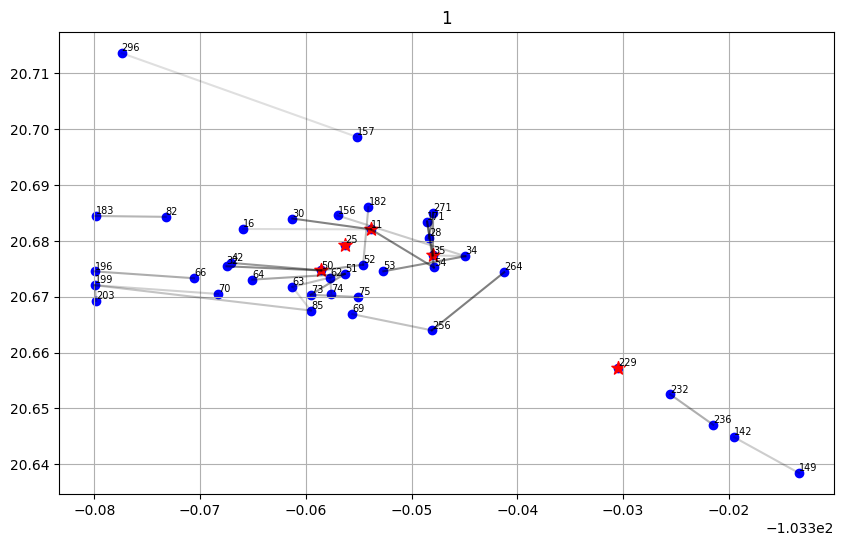

In [45]:
plot_counter(counts_data, estaciones, 1)

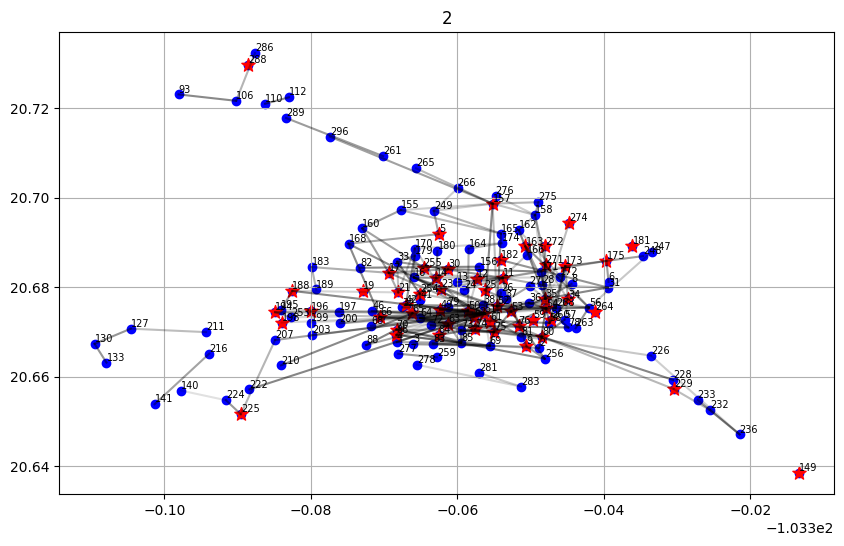

In [44]:
plot_counter(counts_data2, estaciones, 2)

In [37]:
counts_data

,Est_A,Est_B,counts,prob
0,229,229,22,0.097345
1,35,35,15,0.066372
2,157,296,9,0.039823
3,11,16,8,0.035398
4,63,85,8,0.035398
5,25,25,8,0.035398
6,34,35,7,0.030973
7,70,199,7,0.030973
8,142,149,6,0.026549
9,34,156,6,0.026549


In [62]:
counts_prueba = counts_data[counts_data['Est_A'] != counts_data['Est_B']]
counts_prueba

,Est_A,Est_B,counts,prob
2,157,296,9,0.039823
3,11,16,8,0.035398
4,63,85,8,0.035398
6,34,35,7,0.030973
7,70,199,7,0.030973
8,142,149,6,0.026549
9,34,156,6,0.026549
10,62,74,6,0.026549
11,85,199,6,0.026549
12,69,256,6,0.026549


In [17]:
counts_data2

,Est_A,Est_B,counts,prob
22,2,54,5,0.002473
28,2,69,6,0.002967
84,3,69,5,0.002473
119,4,51,5,0.002473
138,4,85,6,0.002967
...,...,...,...,...
4858,272,272,6,0.002967
4860,274,274,6,0.002967
4874,278,283,9,0.004451
4882,281,283,7,0.003462


In [98]:
def compute_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = current_trip["counts"]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = np.sqrt(D) @ matrix @ np.sqrt(D)
    return matrix

In [100]:
m1 = compute_matrix(counts_data, normalized = True)
m2 = compute_matrix(counts_data2, normalized = True)

In [102]:
m1.shape, m2.shape

((40, 40), (142, 142))

In [92]:
mx = np.kron(m1, m2)

dx = np.sum(mx, axis = 1)

px = np.ones(len(dx)) / len(dx)
qx = np.ones(len(dx)) / len(dx)

f_alpha = lambda n: alpha_laplace(0.1, n, 1)

f_vec = lambda n: compute_f_vector(f_alpha, n)

p_h = 0.15

K = kernel_graph_random_features(mx, dx, f_vec, px, qx, p_h)

In [93]:
K

0.00017605633808420585

In [127]:
mx = np.kron(m1, m1)

dx = np.sum(mx, axis = 1)

px = np.ones(len(dx)) / len(dx)
qx = np.ones(len(dx)) / len(dx)

f_alpha = lambda n: alpha_laplace(0.18, n, 1)

f_vec = lambda n: compute_f_vector(f_alpha, n)

p_h = 0.2

In [128]:
K = kernel_graph_random_features(mx, dx, f_vec, px, qx, p_h)
K

1.45448064120047